In [1]:
import nnapprox as nna
%load_ext autoreload
%autoreload 2

In [2]:
# test MPS backend for development
import torch
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [39]:
# prepare data in dataframe
import pandas as pd
import numpy as np
# make grid
x1, x2 = np.meshgrid(np.linspace(0,10,101), np.linspace(0,10,101))
x1 = x1.flatten()
x2 = x2.flatten()
def y_true(x1, x2):
    return 2*x1 + 3*x2**2 + 1
data = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y_true(x1, x2)})
print(data)

         x1    x2      y
0       0.0   0.0    1.0
1       0.1   0.0    1.2
2       0.2   0.0    1.4
3       0.3   0.0    1.6
4       0.4   0.0    1.8
...     ...   ...    ...
10196   9.6  10.0  320.2
10197   9.7  10.0  320.4
10198   9.8  10.0  320.6
10199   9.9  10.0  320.8
10200  10.0  10.0  321.0

[10201 rows x 3 columns]


In [41]:
func = nna.create_approximator(backend="torch", 
                               input=['x1', 'x2'],
                               output=['y'],
                               hidden_dims=[60, 60], 
                               verbose=True, 
                               )

# specify a map from input to NN (inverse not needed)
# if we have a guess on the function, we can help the NN by transforming the inputs accordingly
func.set_transform('x2', forward = lambda x: x**2, inverse = lambda x: np.sqrt(x))
func.fit(data, epochs=10_000, l1r=1e-3, amsgrad=True)
# func.fit(data, epochs=10_000, device=device, l1r=1e-3, amsgrad=True)

TypeError: PyTorchApproximator.fit() missing 1 required keyword-only argument: 'device'

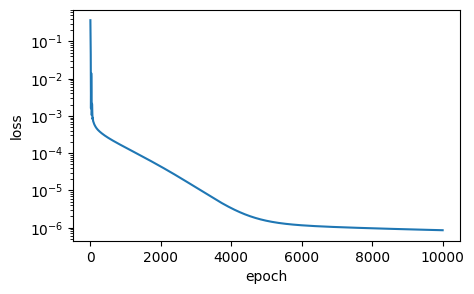

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,3))
plt.plot(func.training_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')

In [6]:
# call function scalar
x1 = 3.0
x2 = 4.0
y_pred = func(x1, x2)
# compare to true value
print(f"Predicted: {y_pred}, True: {y_true(x1, x2)}")
# call function array
x1 = [1,2,]
x2 = [3,4,]
y_pred = func(x1, x2)
# compare to true value
print(f"Predicted: {y_pred}, True: {y_true(np.array(x1), np.array(x2))}")
# call function mixed
x1 = 5.0
x2 = [6,7,8]
y_pred = func(x1, x2)
# compare to true value
print(f"Predicted: {y_pred}, True: {y_true(x1, np.array(x2))}")
# call function dataframe
data_in = pd.DataFrame({'x1': [1,2,3], 'x2': [4,5,6]})
y_pred = func(data_in)
# compare to true value
print(f"Predicted: {y_pred}, True: {y_true(data_in['x1'], data_in['x2'])}")
# return dataframe
y_pred = func(data_in, return_dataframe=True)

Predicted: 54.879859924316406, True: 55.0
Predicted: [29.784397 52.7751  ], True: [30 53]
Predicted: [119.28315 158.07414 202.76884], True: [119. 158. 203.]
Predicted: [ 50.709232  79.93369  115.195076], True: 0     51
1     80
2    115
dtype: int64


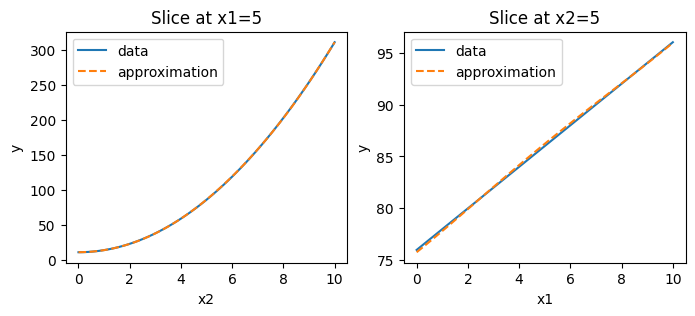

In [7]:
# compare the result
fig, axs = plt.subplots(1,2, figsize=(8,3))
# slice at x1=5
axs[0].set_title('Slice at x1=5')
axs[0].set_xlabel('x2')
axs[0].set_ylabel('y')
data_slice = data[data['x1']==5]
axs[0].plot(data_slice['x2'], data_slice['y'], label='data')
# approximation
x2 = np.linspace(0,10,101)
axs[0].plot(x2, func(5,x2), label='approximation', linestyle='--')
# slice at x2=5
axs[1].set_title('Slice at x2=5')
axs[1].set_xlabel('x1')
axs[1].set_ylabel('y')
data_slice = data[data['x2']==5]
axs[1].plot(data_slice['x1'], data_slice['y'], label='data')
# approximation
x1 = np.linspace(0,10,101)
axs[1].plot(x1, func(x1,5), label='approximation', linestyle='--')
# legends
for ax in axs:
    ax.legend()

In [18]:
# save to pickle file
func.save('test.nna')
func2 = nna.load_approximator('test.nna', backend='torch')
print(func2)

In [19]:
func2.is_fitted

True

In [22]:
#check that it works
pred_1 = func(x1, x2)
pred_2 = func2(x1, x2)
print("Difference after loading:", np.max(np.abs(pred_1 - pred_2)))

Difference after loading: 0.0


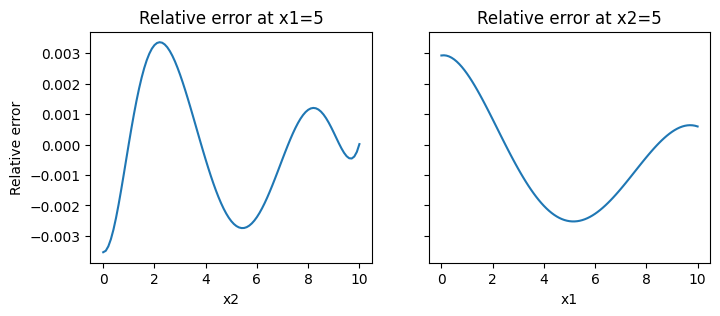

In [23]:
# plot relative error
fig,axs = plt.subplots(1,2, figsize=(8,3), sharey=True)
# slice at x1=5
data_slice = data[data['x1']==5]
axs[0].plot(data_slice['x2'], (data_slice['y']-func(5, data_slice['x2']))/data_slice['y'], label='data')
data_slice = data[data['x2']==5]
axs[1].plot(data_slice['x1'], (data_slice['y']-func(data_slice['x1'], 5))/data_slice['y'], label='data')
axs[0].set_title('Relative error at x1=5')
axs[1].set_title('Relative error at x2=5')
axs[0].set_xlabel('x2')
axs[1].set_xlabel('x1')
axs[0].set_ylabel('Relative error')
plt.show()

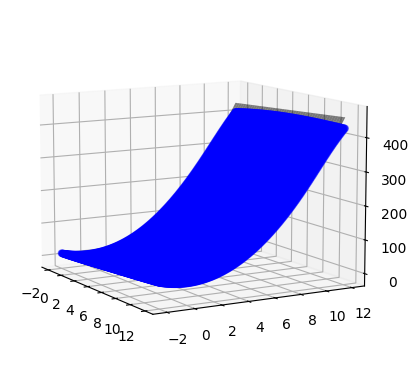

In [24]:
# more general visualization
x1,x2 = np.meshgrid(np.linspace(-2,12,141), np.linspace(-2,12,141))
# plot 2D function
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1, x2, y_true(x1,x2).reshape(141,141), color='k', alpha=0.5)

x1 = x1.flatten()
x2 = x2.flatten()  
# plot 2D function approximation
ax.scatter(x1, x2, func(x1,x2), color='b', alpha=0.5)

# change perspective
ax.view_init(10, -30)

In [25]:
y = func(1,[2,3])
print(y)
x_df = pd.DataFrame({'x1': [1,1], 'x2': [2,3]})
y_df = func(x_df, return_dataframe=True)
y_df

[15.009628 29.784397]


x1  x2          y
0   1   2  15.009628
1   1   3  29.784397

## Second example

In [5]:
import numpy as np
import pandas as pd
x1, x2 = np.meshgrid(np.linspace(0,10,101), np.linspace(0,10,101))
x1 = x1.flatten()
x2 = x2.flatten()
y = np.sin(x1) * np.cos(x2)
data = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})

In [7]:
func = nna.create_approximator(backend="torch", 
                               input=['x1', 'x2'],
                               output=['y'],
                               hidden_dims=[60, 60], 
                               verbose=True, 
                               )
func.fit(data, epochs=1_000, device="cpu", l1r=1e-3, amsgrad=True)

Training data with input shape torch.Size([10201, 2]) and output shape torch.Size([10201, 1]).


Training: 100%|██████████| 1000/1000 [00:04<00:00, 234.36it/s]

Training complete; left training mode for faster evaluation! To re-enter training mode call `func.model.train(True)`.


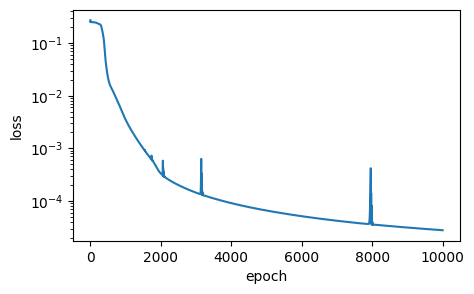

In [29]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,3))
plt.plot(func.training_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')

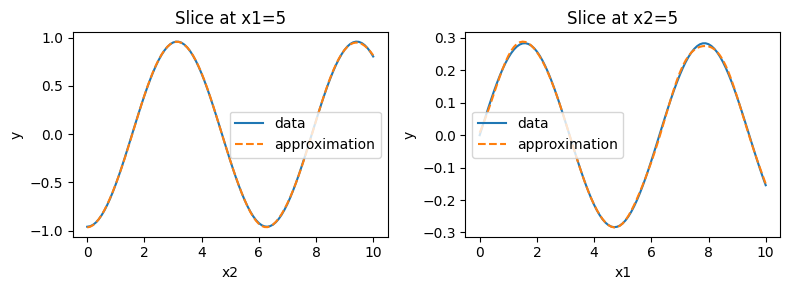

In [30]:
# compare the result
fig, axs = plt.subplots(1,2, figsize=(8,3))
# slice at x1=5
axs[0].set_title('Slice at x1=5')
axs[0].set_xlabel('x2')
axs[0].set_ylabel('y')
data_slice = data[data['x1']==5]
axs[0].plot(data_slice['x2'], data_slice['y'], label='data')
# approximation
x2 = np.linspace(0,10,101)
axs[0].plot(x2, func(5,x2), label='approximation', linestyle='--')
# slice at x2=5
axs[1].set_title('Slice at x2=5')
axs[1].set_xlabel('x1')
axs[1].set_ylabel('y')
data_slice = data[data['x2']==5]
axs[1].plot(data_slice['x1'], data_slice['y'], label='data')
# approximation
x1 = np.linspace(0,10,101)
axs[1].plot(x1, func(x1,5), label='approximation', linestyle='--')
# legends
for ax in axs:
    ax.legend()
plt.tight_layout()